In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datashader as ds
from datashader import transfer_functions as tf
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import BasicTickFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")
output_notebook()

import warnings
warnings.filterwarnings('ignore')

data_detail = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity_detail.tsv', sep='\t',on_bad_lines='skip')

Loading BokehJS ...

# 5.2 Student Learning Behavior Analysis

In [26]:
# Calculating the time gap between created_at and updated_at timestamps
data_detail['created_at'] = pd.to_datetime(data_detail['created_at'])
data_detail['updated_at'] = pd.to_datetime(data_detail['updated_at'])
data_detail['time_gap'] = (data_detail['updated_at'] - data_detail['created_at']).dt.total_seconds() 

df_filtered = data_detail[(data_detail['time_gap'] <= 60*10) & (data_detail['time_gap'] > 0)]

# Create a histogram for the filtered data
hist, edges = np.histogram(df_filtered['time_gap'], bins=30)

# Convert histogram to a DataFrame for datashader
df_hist = pd.DataFrame({'time_gap': edges[:-1], 'count': hist})

# Use datashader to aggregate and visualize
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=(df_hist['time_gap'].min(), df_hist['time_gap'].max()), y_range=(0, df_hist['count'].max()))
agg = canvas.line(df_hist, 'time_gap', 'count')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='linear')

p = figure(width=800, height=400, title='Distribution of Time Gap between Created and Updated Timestamps')
p.image_rgba(image=[img.data], x=df_hist['time_gap'].min(), y=0, dw=df_hist['time_gap'].max(), dh=df_hist['count'].max())

# Format x-axis ticks to not use scientific notation
p.xaxis.formatter = BasicTickFormatter(use_scientific=False)
p.yaxis.formatter = BasicTickFormatter(use_scientific=False)

p.xaxis.axis_label = 'Time Gap (seconds)'
p.yaxis.axis_label = 'Frequency'

In [27]:
show(p)

## Label Learning Behavior

This {code}`Code.org Student Behavior Categories` table categorizes student engagement behaviors on the Code.org learning platform based on specific criteria extracted from log files. The log files record student interactions with each activity, and by interpreting these logs, educators can gain insights into individual and collective learning patterns. The table defines six distinct behaviors, from those who may be struggling with understanding to those who excel rapidly. Each behavior is characterized by its criteria, a brief description, and implications for teaching interventions.

| Learning Behavior       | Criteria                                           | Description                                                                                               | Implications                                                                                                        |
|-------------------------|----------------------------------------------------|-----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| One-shot Failures       | Single attempt and result is "Failed"              | Students who attempt a problem only once and fail.                                                        | Might lack understanding or confidence. They could benefit from initial guidance or examples before attempting problems. |
| Strugglers              | More than 3 attempts with a result of "Failed"     | Students who repeatedly try but still don't succeed.                                                      | Require additional resources, perhaps more foundational material or one-on-one sessions to address their challenges.  |
| Suboptimal Success      | Result is "Pass (Not Optimal)"                     | Students who pass but not in the best possible way.                                                       | Might have gaps in understanding. Consider providing detailed feedback and alternative solutions.                      |
| Rapid Guessing          | More than 1 attempt, with each attempt <5 seconds, and result is either "Optimal" or "Pass" | Students who make quick consecutive attempts and eventually succeed.                                        | Encourage them to slow down and understand problems. Offering hints after a certain time might discourage rapid guessing. |
| Consistent Learner      | More than 3 attempt, longer time gaps (>60 seconds), and result is "Optimal" | Students who might not get it right the first time but show a pattern of steadily improving results over successive attempts without rapid guessing. | Encourage this behavior and provide additional resources for deep dives into topics.                                 |
| Succeed at First Trial  | Single attempt with a result of "Optimal"          | Students who understand and solve problems on their first attempt.                                          | Consider providing more challenging tasks or further material to such students to keep them engaged and challenged.    |
| Others                  | Those not falling into the above categories. | Category for behaviors not captured above or outlier behaviors.                                   |                                 |


## Student Engagement Behavior Analysis

Our aim was to identify various student profiles/clusters based on their learning behaviors, such as those who are 'rapid guessers', students who 'succeed on their first attempt', and those who 'fail' at their tasks. 

The analysis included the following three steps:

1. Filtering the Dataset:
We began by refining our dataset to keep only the most relevant records. We excluded entries where there were zero attempts, ensuring we only focused on students who engaged with the activity. Additionally, we also removed records that had a negative time gap or a time gap exceeding three hours. This step ensures that the data we're analyzing is both relevant and meaningful.

2. Exploratory Data Analysis:
After refining the data, we dived deep into understanding its nuances. We obtained descriptive statistics for various features such as the number of attempts, the time gaps between attempts, and the frequency of learning behaviors. We also visualized these statistics to gain a clearer understanding of their distribution and significance.

3. Identifying Learning Behaviors:
Based on the insights gathered from our exploratory analysis, we categorized students into different behavioral groups. This will help us tailor educational strategies to best suit each group's unique needs.

### Exploratory Data Analysis

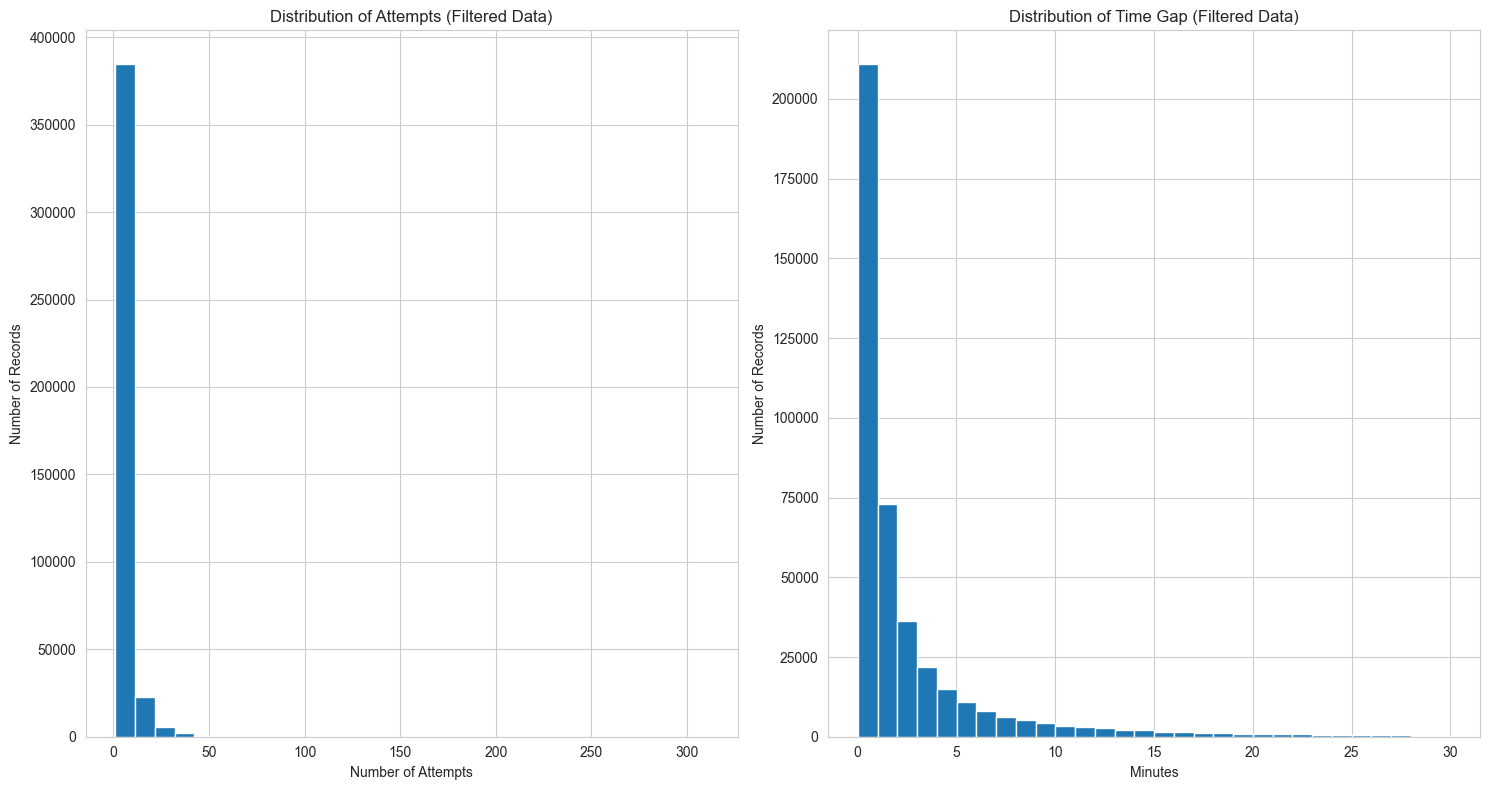

In [28]:
# Step 1: Filtering the data based on the given criteria
filtered_data = data_detail[(data_detail['attempts'] != 0) & 
                     (data_detail['time_gap'] > 0) & 
                     (data_detail['time_gap'] <= 60*30)]

# Step 2: Exploratory Data Analysis (EDA) for the filtered data

basic_stats_filtered = filtered_data[['attempts', 'time_gap']].describe().apply(lambda s: s.apply('{0:.1f}'.format))

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Histogram for attempts
ax[0].hist(filtered_data['attempts'], bins=30)
ax[0].set_title('Distribution of Attempts (Filtered Data)')
ax[0].set_xlabel('Number of Attempts')
ax[0].set_ylabel('Number of Records')

# Histogram for time_gap
ax[1].hist(filtered_data['time_gap']/60, bins=30)
ax[1].set_title('Distribution of Time Gap (Filtered Data)')
ax[1].set_xlabel('Minutes')
ax[1].set_ylabel('Number of Records')

plt.tight_layout()
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[1].ticklabel_format(useOffset=False, style='plain')

In [29]:
basic_stats_filtered

,attempts,time_gap
count,416676.0,416676.0
mean,4.9,154.6
std,6.0,249.8
min,1.0,1.0
25%,2.0,22.0
50%,3.0,59.0
75%,5.0,164.0
max,311.0,1800.0


**Attempts**:

Average number of attempts is approximately 5. 50% of the records (median) have 3 attempts, with the maximum number of attempts being 311.

**Time Gap**:

The average time gap is approximately 2.5 minutes. The median time gap is 1 minute. The maximum time gap observed is 30 minutes, which aligns with our filter.

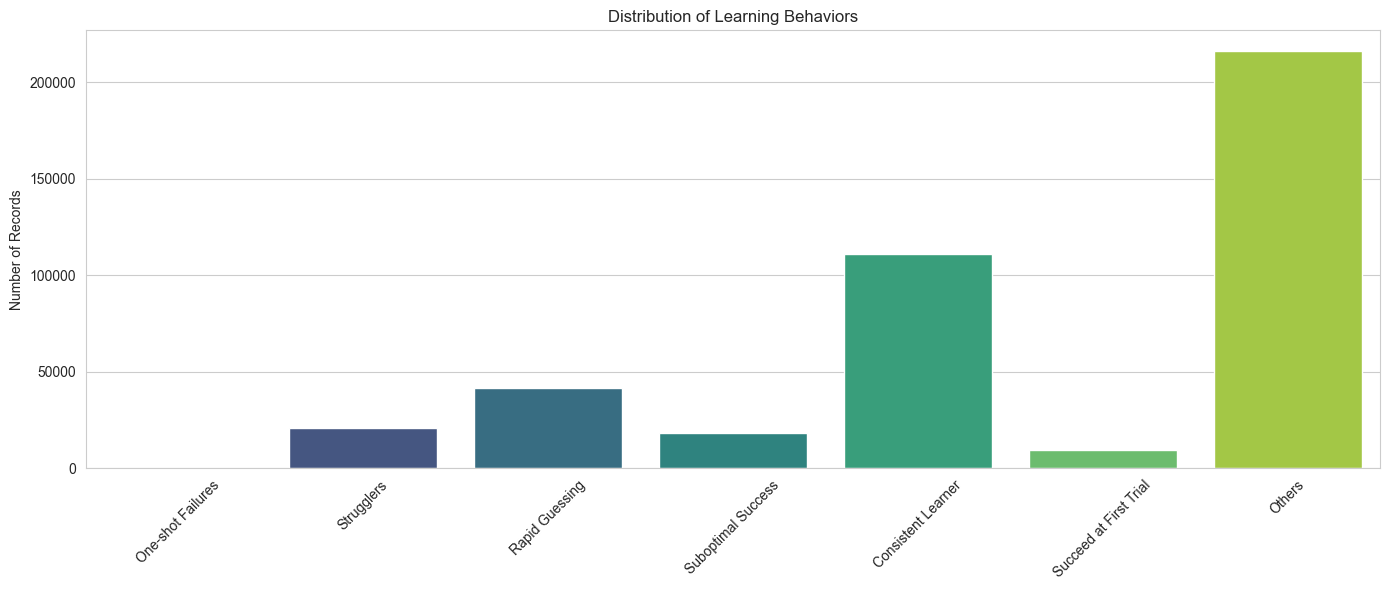

In [40]:
 #Step 3: Identify Learning Behaviors for the filtered data

# label each row in the filtered_data with its appropriate learning behavior
"""
def assign_behavior_label(row):
    if (row['attempts'] == 1) and (row['test_result_category'] == 'Failed'):
        return "One-shot Failures"
    elif (row['attempts'] > 3) and (row['test_result_category'] == 'Failed'):
        return "Strugglers"
    elif row['test_result_category'] == 'Pass (Not Optimal)':
        return "Suboptimal Success"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Optimal'):
        return "Succeed at First Trial"
    elif (row['attempts'] > 1) and (row['time_gap'] < 12) and (row['test_result_category'] == 'Optimal'):
        return "Rapid Guessing"
    elif (row['attempts'] > 1) and (row['time_gap'] > 60) and (row['test_result_category'] == 'Optimal'):
        return "Reflective Learner"
    else:
        return "Others"
"""
def categorize_test_result(result):
    if result < 20 and result != -1:
        return 'Failed'
    elif 20 <= result < 30:
        return 'Pass (Not Optimal)'
    elif 30 <= result < 1000:
        return 'Optimal'
    else:
        return 'Special'
filtered_data['test_result_category'] =filtered_data['best_result'].apply(categorize_test_result)

def assign_behavior_label(row):
    # Check for Rapid Guessing first
    if (row['attempts'] > 1) and (row['time_gap'] / row['attempts'] <= 5) and (row['test_result_category'] in ['Optimal', 'Pass (Not Optimal)']):
        return "Rapid Guessing"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Failed'):
        return "One-shot Failures"
    elif (row['attempts'] > 3) and (row['test_result_category'] == 'Failed'):
        return "Strugglers"
    elif row['test_result_category'] == 'Pass (Not Optimal)':
        return "Suboptimal Success"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Optimal'):
        return "Succeed at First Trial"
    elif (row['attempts'] > 3) and (row['time_gap'] > 60) and (row['test_result_category'] == 'Optimal'): #both over 50%
        return "Consistent Learner"
    else:
        return "Others"

    
def plot_learning_behaviors(behavior_counts):
    # Ensure the order of categories as specified
    categories = ["One-shot Failures", "Strugglers", "Rapid Guessing", "Suboptimal Success","Consistent Learner","Succeed at First Trial", "Others"]
    counts = [behavior_counts.get(cat, 0) for cat in categories]

    # Plotting
    plt.figure(figsize=(14, 6))
    sns.barplot(x=categories, y=counts, palette="viridis")
    plt.ylabel('Number of Records')
    plt.title('Distribution of Learning Behaviors')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

filtered_data['behavior_label'] = filtered_data.apply(assign_behavior_label, axis=1)

behavior_counts = filtered_data['behavior_label'].value_counts()

In [ ]:
plot_learning_behaviors(behavior_counts)